# IQ Prediction using Linear Regression

Load libraries

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures


## Transform and clean the data

The data is currently in long format. It is converted into wide format using the pandas pivot function. With each feature in single column and each row corresponding to a signle entry, it will be easy to understand the data, and quickly apply the functions to get statistics about the data.

The variables are renamed to give better understanding of what they represent.
- a -> mothers_age: mother's age at child's birth
- i -> mothers_iq: mother's IQ
- h -> mother_high_school_grad: indicator showing whether mother completed high school (1=True, 0=False)
- w -> mother_start_work = 1: mother did not work in first three years of child’s life
- w -> mother_start_work = 2: mother worked in second or third year of child’s life
- w -> mother_start_work = 3: mother worked part-time in first year of child’s life
- w -> mother_start_work = 4: mother worked full-time in first year of child’s life


In [2]:
df = pd.read_csv("data.txt", sep="|")
df = df.drop(df.columns[0], axis=1)

df

,variable,value
0,score,65
1,score,98
2,score,85
3,score,83
4,score,115
...,...,...
2165,a,21
2166,a,23
2167,a,24
2168,a,21


In [3]:
df['variable'].value_counts()

score    434
h        434
i        434
w        434
a        434
Name: variable, dtype: int64

In [4]:
df.index = np.tile(range(0,434), 5)

df = pd.pivot(df, values='value', columns=['variable']).rename_axis(None, axis=1)

df.head()

,a,h,i,score,w
0,27,1,'121.117528602603',65,4
1,25,1,'89.3618817100663',98,4
2,27,1,'115.443164881725',85,4
3,25,1,'99.4496394360723',83,3
4,27,1,'92.7457099982118',115,4


In [5]:
df = df.rename(
columns= {
    'a':'mothers_age',
    'i':'mothers_iq',
    'h':'mother_high_school_grad',
    'w':'mother_start_work'
})

df.head()

,mothers_age,mother_high_school_grad,mothers_iq,score,mother_start_work
0,27,1,'121.117528602603',65,4
1,25,1,'89.3618817100663',98,4
2,27,1,'115.443164881725',85,4
3,25,1,'99.4496394360723',83,3
4,27,1,'92.7457099982118',115,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   mothers_age              434 non-null    object
 1   mother_high_school_grad  434 non-null    object
 2   mothers_iq               434 non-null    object
 3   score                    434 non-null    object
 4   mother_start_work        434 non-null    object
dtypes: object(5)
memory usage: 20.3+ KB


## Explore the data

The dataset has 434 entries and 5 features. There are no null values in the dataset.

- `mother_high_school_grad`, `mother_start_work` are categorical and is converted to the datatype category with integer values
- `mothers_age` is continuous and is converted to the datatype int32  
- `mothers_iq` and `score` are continuous and is converted to the datatype float32


In [7]:
df['mothers_iq'] = df['mothers_iq'].str.replace("\'",'',regex=True)
df = df.astype(
{
    'mothers_age':'int32',
    'mother_high_school_grad':'int32',
    'mother_start_work':'int32',
    'mothers_iq':'float32',
    'score':'float32'
})

df = df.astype(
{
    'mother_high_school_grad':'category',
    'mother_start_work':'category'
})

In [8]:
df.describe()

,mothers_age,mothers_iq,score
count,434.000000,434.000000,434.000000
mean,22.785714,99.999908,86.797234
std,2.701070,14.999997,20.410690
min,17.000000,71.037407,20.000000
25%,21.000000,88.660324,74.000000
50%,23.000000,97.915253,90.000000
75%,25.000000,110.272745,102.000000
max,29.000000,138.893112,144.000000


In [9]:
df.describe(include=['category'])



,mother_high_school_grad,mother_start_work
count,434,434
unique,2,4
top,1,4
freq,341,205


[Text(0.5, 0, "Child's IQ"), Text(0, 0.5, 'Count'), Text(0.5, 1.0, '')]

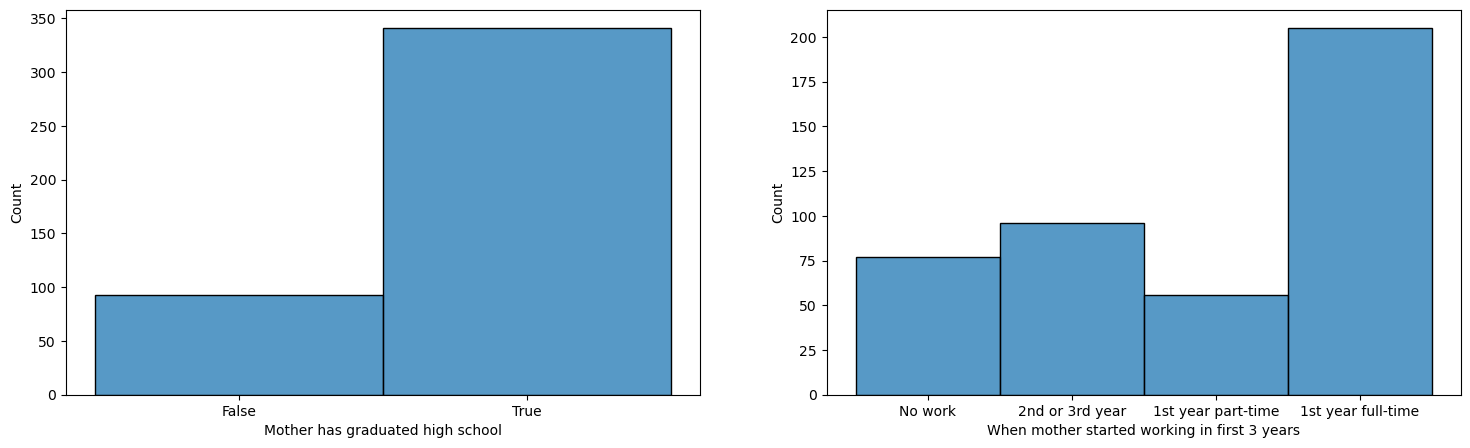

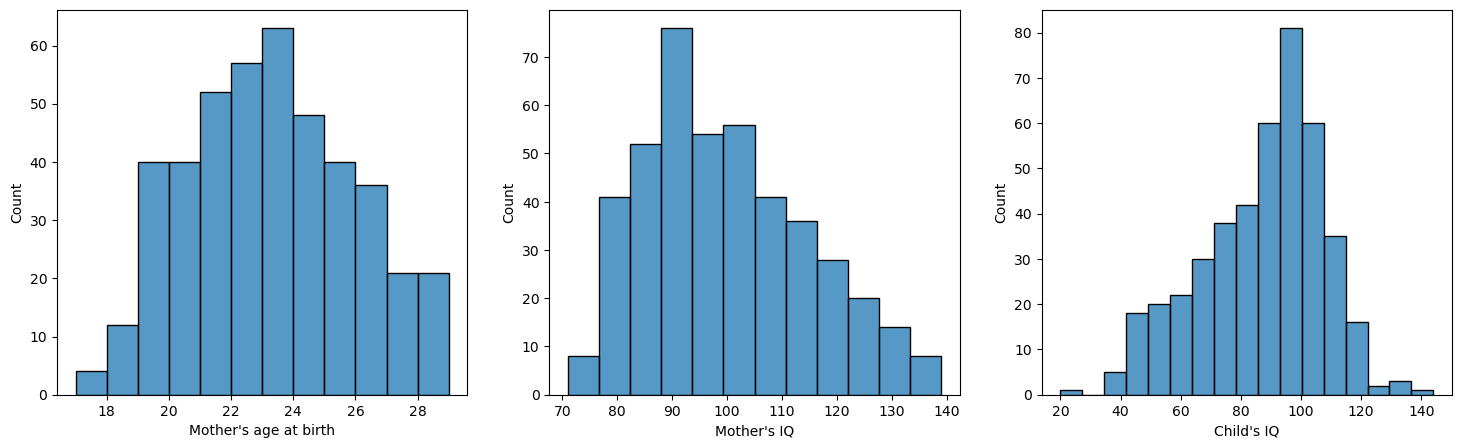

In [10]:
fig, ax = plt.subplots(1,2,figsize=(18, 5))
sns.histplot(ax=ax[0], data=df, x="mother_high_school_grad")
ax[0].set(xlabel='Mother has graduated high school', ylabel='Count', title='')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['False', 'True'])

sns.histplot(ax=ax[1], data=df, x="mother_start_work")
ax[1].set(xlabel='When mother started working in first 3 years', ylabel='Count', title='')
ax[1].set_xticks([1, 2, 3, 4])
ax[1].set_xticklabels(['No work', '2nd or 3rd year', '1st year part-time','1st year full-time'])

fig, ax = plt.subplots(1,3,figsize=(18, 5))
sns.histplot(ax=ax[0], data=df, x="mothers_age")
ax[0].set(xlabel='Mother\'s age at birth', ylabel='Count', title='')

sns.histplot(ax=ax[1], data=df, x="mothers_iq")
ax[1].set(xlabel='Mother\'s IQ', ylabel='Count', title='')

sns.histplot(ax=ax[2], data=df, x="score")
ax[2].set(xlabel='Child\'s IQ', ylabel='Count', title='')

[Text(0.5, 0, "Mother's IQ"), Text(0, 0.5, "Child' IQ")]

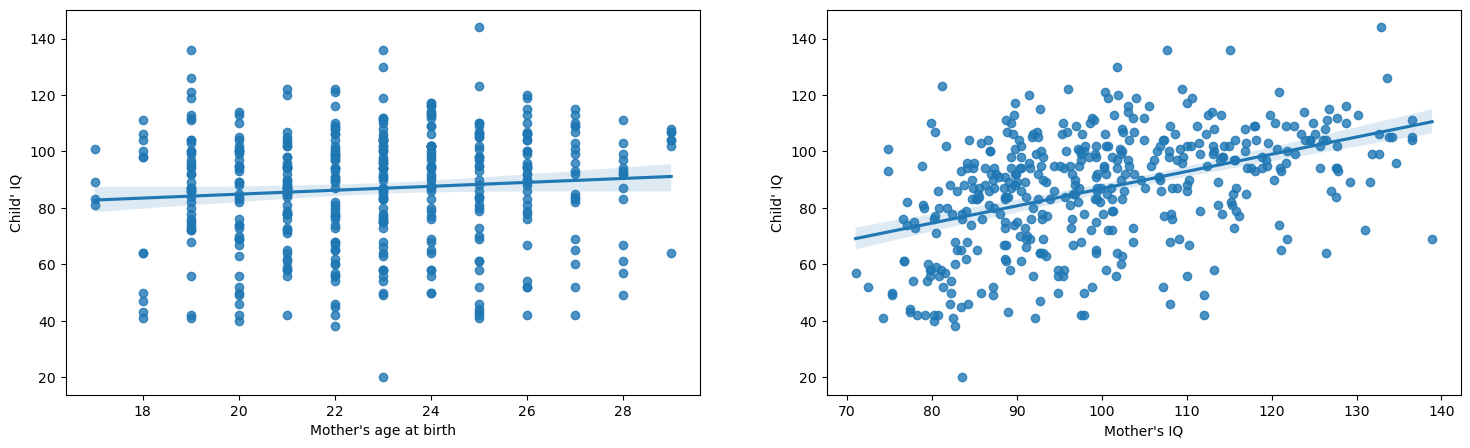

In [11]:
fig, ax = plt.subplots(1,2,figsize=(18, 5))
sns.regplot(ax=ax[0], data=df, x="mothers_age", y="score")
ax[0].set(xlabel='Mother\'s age at birth', ylabel='Child\' IQ')

sns.regplot(ax=ax[1], data=df, x="mothers_iq", y="score")
ax[1].set(xlabel='Mother\'s IQ', ylabel='Child\' IQ')

### Observations from the features

- Most mothers have graduated high school
    - Frequency is 341
- Most mothers were working full time the first year their child was born
    - Frequency is 205
  
- Mean age of the mothers is 23 years old when they gave birth
- The mean of mother's IQ is 99.999908
- The mean of child's IQ is 86.797234
- There is a positive correlation between the mother's IQ and child's IQ
- There isn't much correlation between mother's age at birth of the child and the IQ of the child

<AxesSubplot:xlabel='mothers_age', ylabel='score'>

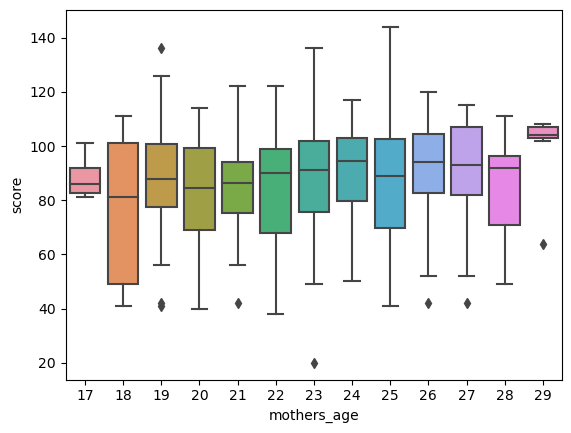

In [12]:
sns.boxplot(data=df, x="mothers_age", y="score")


In [13]:
df['mothers_age_binned']= pd.cut(df["mothers_age"].astype('int32'), bins=[16,21,25,30], labels=[1,2,3])


<AxesSubplot:xlabel='mothers_iq', ylabel='score'>

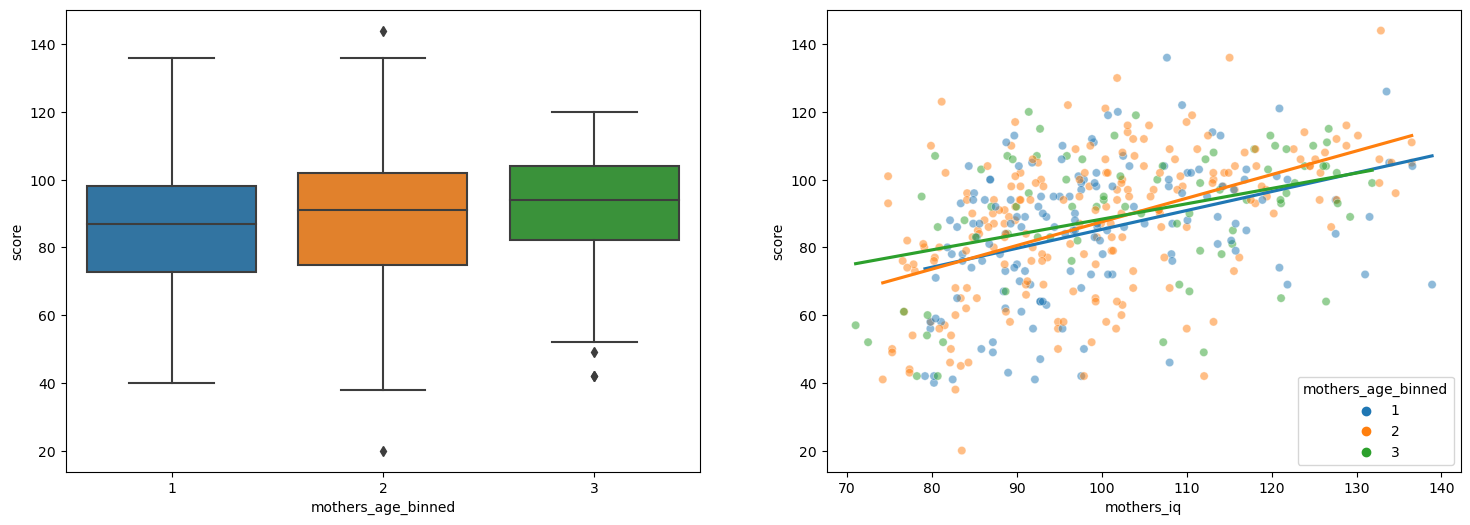

In [14]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

sns.boxplot(ax=ax[0], data=df, x="mothers_age_binned", y="score")
sns.scatterplot(ax=ax[1], data=df, x="mothers_iq", hue="mothers_age_binned", y="score", alpha=0.5)
sns.regplot(ax=ax[1], data=df[df['mothers_age_binned'] == 1], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[0])
sns.regplot(ax=ax[1], data=df[df['mothers_age_binned'] == 2], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[1])
sns.regplot(ax=ax[1], data=df[df['mothers_age_binned'] == 3], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[2])



<AxesSubplot:xlabel='mothers_iq', ylabel='score'>

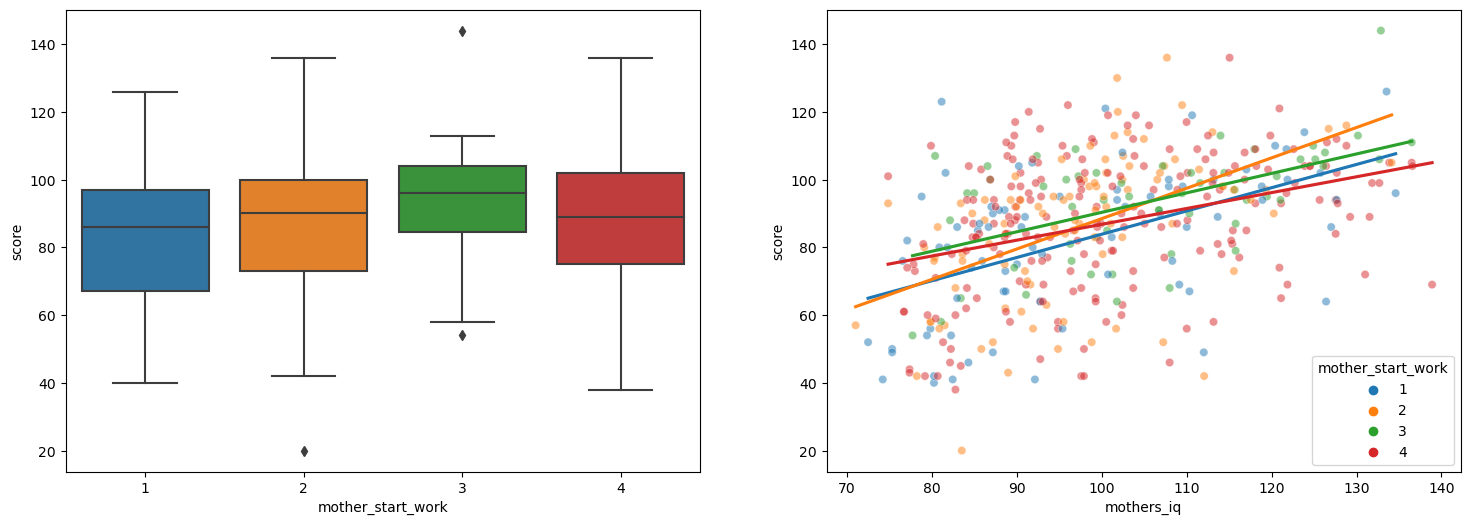

In [15]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

sns.boxplot(ax=ax[0], data=df, x="mother_start_work", y="score")
sns.scatterplot(ax=ax[1], data=df, x="mothers_iq", hue="mother_start_work", y="score", alpha=0.5)
sns.regplot(ax=ax[1], data=df[df['mother_start_work'] == 1], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[0])
sns.regplot(ax=ax[1], data=df[df['mother_start_work'] == 2], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[1])
sns.regplot(ax=ax[1], data=df[df['mother_start_work'] == 3], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[2])
sns.regplot(ax=ax[1], data=df[df['mother_start_work'] == 4], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[3])



<AxesSubplot:xlabel='mothers_iq', ylabel='score'>

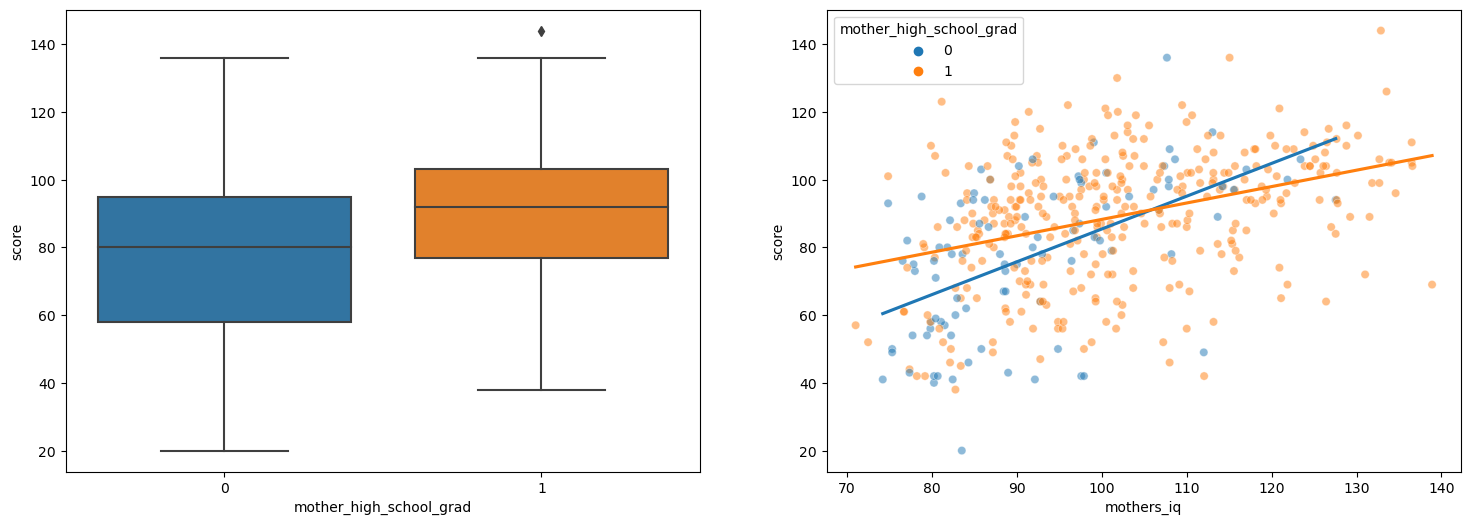

In [16]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

sns.boxplot(ax=ax[0], data=df, x="mother_high_school_grad", y="score")
sns.scatterplot(ax=ax[1], data=df, x="mothers_iq", hue="mother_high_school_grad", y="score", alpha=0.5)
sns.regplot(ax=ax[1], data=df[df['mother_high_school_grad'] == 0], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[0])
sns.regplot(ax=ax[1], data=df[df['mother_high_school_grad'] == 1], x="mothers_iq", y="score", scatter=False, ci=False, color=sns.color_palette("tab10")[1])


### Observations

Mother's Age `mothers_age`
- Treating age as categorical, mother's who gave birth at 29 their child has the highest median child's IQ. 
- The age is then binned into 3 categories to see how the age interacts with mother's IQ to determine the child's IQ. The bins are (16,21], (21,25], (25,30].
- The regression plot with child's IQ and mother's IQ for mother's ages in (21,25] has the steepest slope. It could be because the range of the child's IQ for this bin is large.
- All three regression plots intersect each other, so their is interaction between mother's age at birth and mother's IQ.

When mother's started to work `mother_start_work`
- The median child's IQ is highest with the mother's who worked part time during first year of child birth.
- The regression plot with child's IQ and mother's IQ for mother's who worked in second and third year of the child.
- There is some interaction between mother's IQ and the year when mother started to work

Whether mother graduated high school `mother_high_school_grad`
- The median child's IQ for mother's who have graduated high school is higher than mother's who did not.
- The regression plot with child's IQ and mother's IQ for mother's who graduated high school is steeper.
- There is interaction between mother's IQ and whether mother's graduated high school or not.



### Feature Selection



F-test is implemented for regression in sklearn library using the f_regression function. This score is being used to pick the best features.

PolynomialFeatures is used to get the interaction terms only for the gien features, and then f-score is used to identify the best features. 

In [17]:
X = df.drop(columns=['score', 'mothers_age_binned'])
y = df['score']

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

f_test = pd.DataFrame(f_test, index=X.columns, columns=['f-score']).sort_values(by=['f-score'], ascending=False)

f_test.style.background_gradient(cmap='Greens')

,f-score
mothers_iq,1.000000
mother_high_school_grad,0.236461
mothers_age,0.033942
mother_start_work,0.030698


In [18]:
poly = PolynomialFeatures(interaction_only=True)

interaction_X = poly.fit_transform(X)
interaction_X = pd.DataFrame(interaction_X,columns=poly.get_feature_names_out()).drop(columns = ['1'])

f_test, _ = f_regression(interaction_X, y)
f_test /= np.max(f_test)

f_test = pd.DataFrame(f_test, index=interaction_X.columns, columns=['f-score']).sort_values(by=['f-score'], ascending=False)

f_test.style.background_gradient(cmap='Greens')

,f-score
mothers_iq,1.000000
mothers_age mothers_iq,0.700324
mother_high_school_grad mothers_iq,0.452024
mothers_age mother_high_school_grad,0.273295
mother_high_school_grad,0.236461
mothers_iq mother_start_work,0.194134
mother_high_school_grad mother_start_work,0.135897
mothers_age mother_start_work,0.050444
mothers_age,0.033942
mother_start_work,0.030698


## Linear Regression

In [19]:
result_rmse = []

### Single Variable

As mother's IQ has the highest f-score, `mothers_iq` is used as the feature for training the linear regression model. This model gives a RMSE of 18.2239.

In [20]:
mothers_iq = X['mothers_iq'].values.reshape(-1, 1)

s_reg = OLS(y, mothers_iq)\
        .fit()

y_test = s_reg.predict(mothers_iq)

result_rmse = result_rmse + [['Single Variable',np.sqrt(mean_squared_error(y_test,y))]]

In [21]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y)))

RMSE:  18.620626


In [22]:
s_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  score   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              9494.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):                   1.20e-296
Time:                        22:15:24   Log-Likelihood:                         -1885.0
No. Observations:                 434   AIC:                                      3772.
Df Residuals:                     433   BIC:                                      3776.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8623      0.009     97.439      0.000       0.845       0.880
==============================================================================
Omnibus:                        4.019   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                4.048
Skew:                          -0.234   Prob(JB):                        0.132
Kurtosis:                       2.937   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Actual', ylabel='Predictions'>

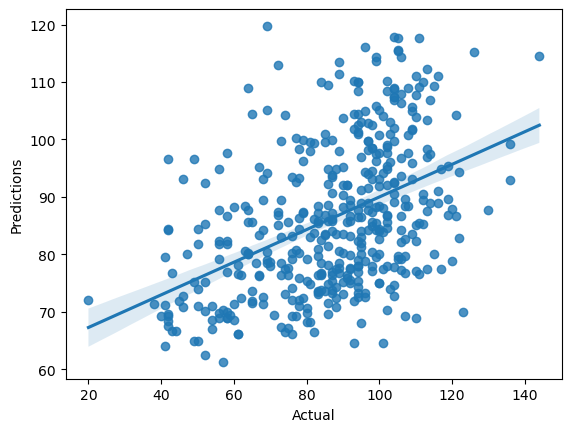

In [23]:
single_var = pd.concat([y,pd.DataFrame(y_test, columns=['Predictions'])], axis=1).rename(columns={'score':'Actual'})
sns.regplot(data=single_var, x="Actual", y="Predictions")

- 95.6% of the variation in child's IQ can be explained by the predictor variable `mothers_iq`
- F-statistic of 9494 with Degree of Freedom of 1 tells that this model fit the data better than intercept only model.
- `mothers_iq` has significant impact on `score` as P>|t| is close to 0.

Linear Regression Equation : `score`  =  (0.8623) `mothers_iq`

## Multiple Variables

Two models are trained using different sets of variables.
- Model 1: Uses all the variables. This model gives a RMSE of 18.1703.
- Model 2: Uses `mothers_iq`, `mother_high_school_grad`, and `mothers_age`. This model gives a RMSE of 18.1738.
- Model 3: Uses `mothers_iq` and `mother_high_school_grad`. This model gives a RMSE of 18.2731.

### All Variables

In [24]:
multiple_X = df[['mothers_iq','mother_high_school_grad','mothers_age','mother_start_work']]

m1_reg = OLS(y, multiple_X)\
        .fit()

y_test = m1_reg.predict(multiple_X)

result_rmse = result_rmse + [['All Variables',np.sqrt(mean_squared_error(y_test,y))]]

In [25]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y)))

RMSE:  18.17036206761019


In [26]:
m1_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  score   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              2481.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):                   1.86e-295
Time:                        22:15:24   Log-Likelihood:                         -1874.3
No. Observations:                 434   AIC:                                      3757.
Df Residuals:                     430   BIC:                                      3773.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
mothers_iq                  0.6415      0.050     12.856      0.000       0.543       0.740
mother_high_school_grad     4.6918      2.292      2.047      0.041       0.186       9.197
mothers_age                 0.7846      0.221      3.552      0.000       0.350       1.219
mother_start_work           0.3099      0.767      0.404      0.687      -1.198       1.818
==============================================================================
Omnibus:                        5.831   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.962
Skew:                          -0.280   Prob(JB):                       0.0507
Kurtosis:                       2.877   Cond. No.                         272.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Actual', ylabel='Predictions'>

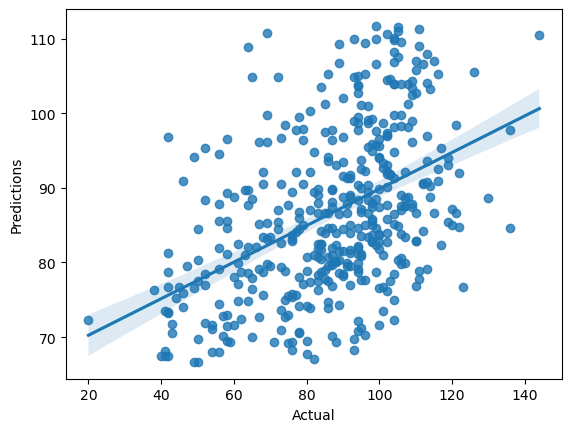

In [27]:
all_var = pd.concat([y,pd.DataFrame(y_test, columns=['Predictions'])], axis=1).rename(columns={'score':'Actual'})
sns.regplot(data=all_var, x="Actual", y="Predictions")

- 95.8% of the variation in child's IQ can be explained by the predictor variables.
- F-statistic of 2481 with Degree of Freedom of 4 tells that this model fit the data better than intercept only model.
- `mothers_iq`, `mother_high_school_grad`, and `mothers_age` have significant impact on `score` as P>|t| is close to 0.

Linear Regression Equation : `score`  =  (0.6415) `mothers_iq` + (4.6918)`mother_high_school_grad` + (0.7846)`mothers_age` + (0.3099)`mother_start_work`

### Three Variables

In [28]:
multiple_X = df[['mothers_iq','mother_high_school_grad','mothers_age']]

m2_reg = OLS(y, multiple_X)\
        .fit()

y_test = m2_reg.predict(multiple_X)

result_rmse = result_rmse + [['Three Variables',np.sqrt(mean_squared_error(y_test,y))]]

In [29]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y)))

RMSE:  18.173807066913152


In [30]:
m2_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  score   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              3314.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):                   3.24e-297
Time:                        22:15:25   Log-Likelihood:                         -1874.4
No. Observations:                 434   AIC:                                      3755.
Df Residuals:                     431   BIC:                                      3767.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
mothers_iq                  0.6440      0.049     13.022      0.000       0.547       0.741
mother_high_school_grad     4.8773      2.244      2.174      0.030       0.467       9.287
mothers_age                 0.8064      0.214      3.768      0.000       0.386       1.227
==============================================================================
Omnibus:                        5.739   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.865
Skew:                          -0.279   Prob(JB):                       0.0533
Kurtosis:                       2.883   Cond. No.                         266.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Actual', ylabel='Predictions'>

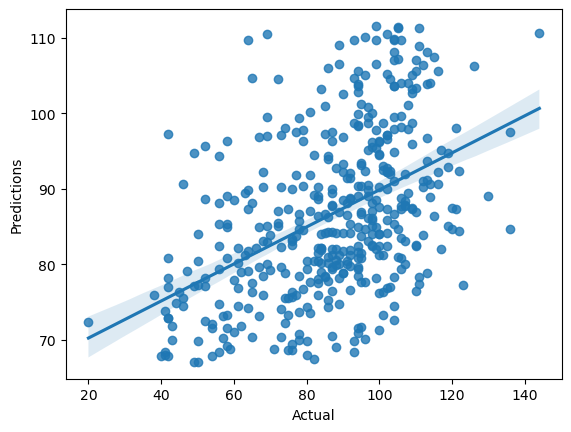

In [31]:
three_var = pd.concat([y,pd.DataFrame(y_test, columns=['Predictions'])], axis=1).rename(columns={'score':'Actual'})
sns.regplot(data=three_var, x="Actual", y="Predictions")

- 95.8% of the variation in child's IQ can be explained by the predictor variables.
- F-statistic of 3314 with Degree of Freedom of 3 tells that this model fit the data better than intercept only model.
- `mothers_iq`, `mother_high_school_grad`, and `mothers_age` have significant impact on `score` as P>|t| is close to 0.

Linear Regression Equation : `score`  =  (0.6440) `mothers_iq` + (4.8773)`mother_high_school_grad` + (0.8064)`mothers_age`

### Two Variables

In [32]:
multiple_X = df[['mothers_iq','mothers_age']]

m3_reg = OLS(y, multiple_X)\
        .fit()

y_test = m3_reg.predict(multiple_X)

result_rmse = result_rmse + [['Two Variable',np.sqrt(mean_squared_error(y_test,y))]]

In [33]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y)))

RMSE:  18.27315579228959


In [34]:
m3_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  score   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              4926.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):                   4.28e-298
Time:                        22:15:25   Log-Likelihood:                         -1876.8
No. Observations:                 434   AIC:                                      3758.
Df Residuals:                     432   BIC:                                      3766.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
mothers_iq      0.6686      0.048     13.829      0.000       0.574       0.764
mothers_age     0.8677      0.213      4.073      0.000       0.449       1.286
==============================================================================
Omnibus:                        6.332   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.435
Skew:                          -0.297   Prob(JB):                       0.0401
Kurtosis:                       2.938   Cond. No.                         25.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Actual', ylabel='Predictions'>

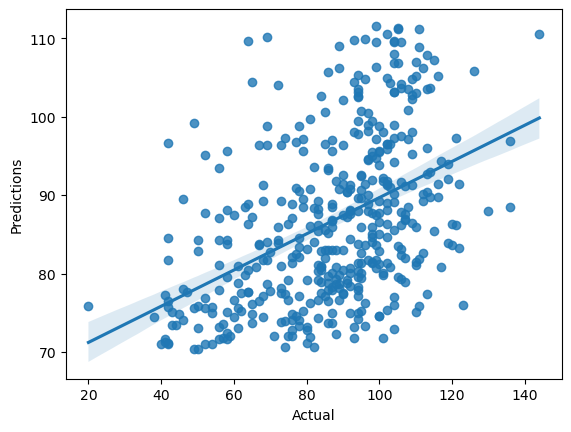

In [35]:
two_var = pd.concat([y,pd.DataFrame(y_test, columns=['Predictions'])], axis=1).rename(columns={'score':'Actual'})
sns.regplot(data=two_var, x="Actual", y="Predictions")

- 95.8% of the variation in child's IQ can be explained by the predictor variables.
- F-statistic of 4926 with Degree of Freedom of 2 tells that this model fit the data better than intercept only model.
- `mothers_iq` and `mothers_age` have significant impact on `score` as P>|t| is 0.

Linear Regression Equation : `score`  =  (0.6686) `mothers_iq` + (0.8677)`mothers_age`

### With Interaction Term

The model is trained using the feature `mothers_iq` and the interaction terms `mothers_age mothers_iq`, `mother_high_school_grad mothers_iq`, `mothers_age mother_high_school_grad`. This models gives and RMSE of 17.8181.
This model has performed the best with the lowest RMSE.

In [36]:
selected_interaction_X = interaction_X[['mothers_iq', 'mothers_age mothers_iq', 'mother_high_school_grad mothers_iq', 'mothers_age mother_high_school_grad']]

reg = OLS(y, selected_interaction_X)\
        .fit()

y_test = reg.predict(selected_interaction_X)

result_rmse = result_rmse + [['With Interaction Terms',np.sqrt(mean_squared_error(y_test,y))]]


In [37]:
print('RMSE: ',np.sqrt(mean_squared_error(y_test,y)))

RMSE:  17.818134162053752


In [38]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  score   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              2584.
Date:                Thu, 15 Dec 2022   Prob (F-statistic):                   4.13e-299
Time:                        22:15:25   Log-Likelihood:                         -1865.8
No. Observations:                 434   AIC:                                      3740.
Df Residuals:                     430   BIC:                                      3756.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
mothers_iq                              1.0649      0.081     13.110      0.000       0.905       1.225
mothers_age mothers_iq                 -0.0102      0.004     -2.778      0.006      -0.017      -0.003
mother_high_school_grad mothers_iq     -0.3452      0.063     -5.513      0.000      -0.468      -0.222
mothers_age mother_high_school_grad     1.7219      0.277      6.221      0.000       1.178       2.266
==============================================================================
Omnibus:                        8.212   Durbin-Watson:                   1.658
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.470
Skew:                          -0.337   Prob(JB):                       0.0145
Kurtosis:                       2.887   Cond. No.                         776.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='Actual', ylabel='Predictions'>

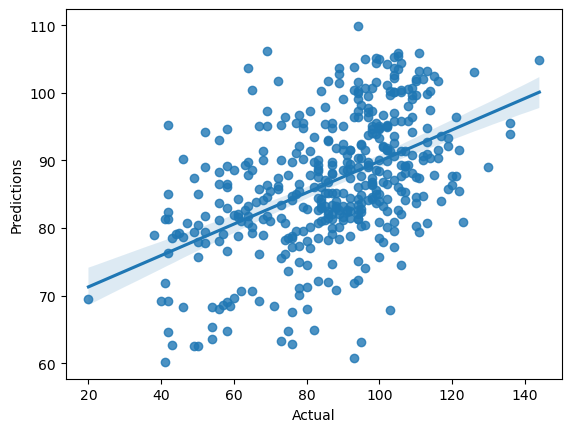

In [39]:
interaction_var = pd.concat([y,pd.DataFrame(y_test, columns=['Predictions'])], axis=1).rename(columns={'score':'Actual'})
sns.regplot(data=interaction_var, x="Actual", y="Predictions")

- 95.8% of the variation in child's IQ can be explained by the predictor variables.
- F-statistic of 4926 with Degree of Freedom of 2 tells that this model fit the data better than intercept only model.
- `mothers_iq` and the interaction terms `mothers_age mothers_iq`, `mother_high_school_grad mothers_iq`, `mothers_age mother_high_school_grad` have significant impact on `score` as P>|t| is close to 0.

Linear Regression Equation: `score` = (1.0649) `mothers_iq` + (-0.0102) `mothers_age mothers_iq` + (-0.3452) `mother_high_school_grad mothers_iq` + (1.7219)`mothers_age mother_high_school_grad`

In [40]:
result_rmse = pd.DataFrame(result_rmse, columns=['Model','RMSE'])

In [41]:
result_rmse.style.background_gradient(cmap='Greens', gmap=-result_rmse['RMSE'])

,Model,RMSE
0,Single Variable,18.620626
1,All Variables,18.170362
2,Three Variables,18.173807
3,Two Variable,18.273156
4,With Interaction Terms,17.818134


Considering all the models, the linear model with the interaction terms has performed the best.